In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./used_car_train_20200313/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('./used_car_testB_20200421/used_car_testB_20200421.csv', sep=' ')
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [3]:
# 剔除std = 0的特征
train.drop(columns = ['offerType', 'seller'], inplace=True)
test.drop(columns = ['offerType', 'seller'], inplace=True)

In [4]:
# 通过对object类型的数据value_counts，发现有字符串类型的异常值'-'
train.select_dtypes('object').value_counts()

notRepairedDamage
0.0                  111361
-                     24324
1.0                   14315
dtype: int64

In [5]:
train.notRepairedDamage.replace('-', '0.0', inplace=True)
train.notRepairedDamage.value_counts()

0.0    135685
1.0     14315
Name: notRepairedDamage, dtype: int64

In [6]:
test.notRepairedDamage.replace('-', '0.0', inplace=True)

In [7]:
train.notRepairedDamage = train.notRepairedDamage.astype('float')
test.notRepairedDamage = test.notRepairedDamage.astype('float')

#### 填充缺失值

In [8]:
#train.info()
fills = ['model', 'bodyType', 'fuelType', 'gearbox']

In [9]:
for i in fills:
    print(i,'缺失：',train[i].isna().sum())
    train[i] = train[i].fillna(train[i].mean())
    test[i] = test[i].fillna(test[i].mean())
    print(i,'补充后：',train[i].isna().sum())
    print('\n')

model 缺失： 1
model 补充后： 0


bodyType 缺失： 4506
bodyType 补充后： 0


fuelType 缺失： 8680
fuelType 补充后： 0


gearbox 缺失： 5981
gearbox 补充后： 0




<AxesSubplot:>

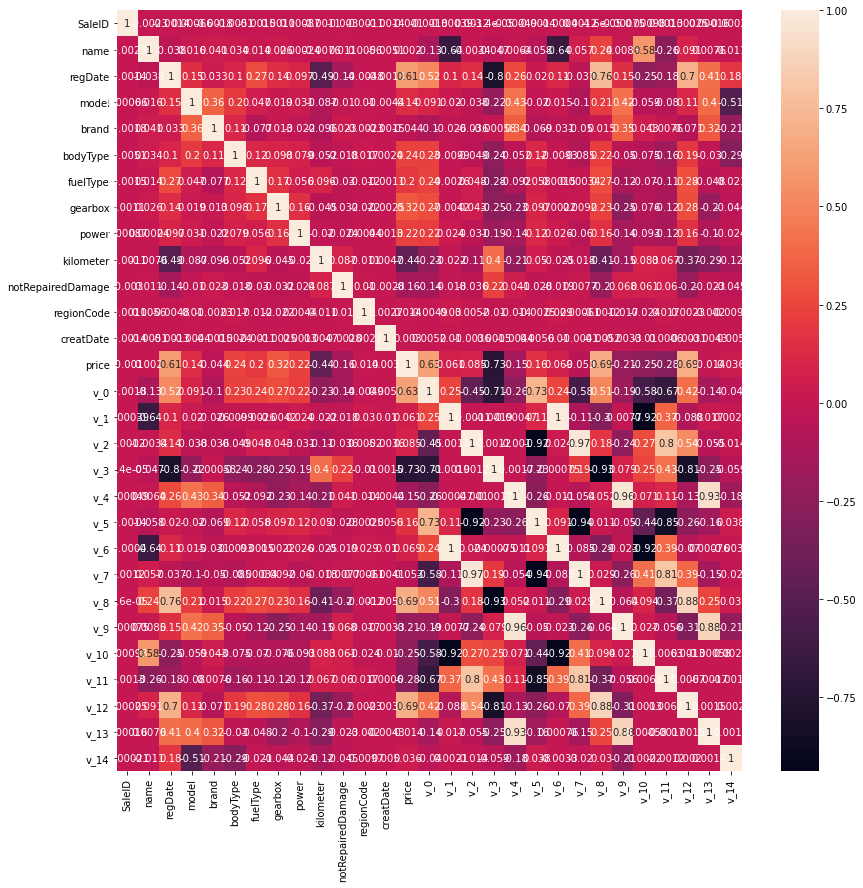

In [10]:
cor = train.corr()
plt.figure(figsize=(14,14))
sns.heatmap(cor, annot=True)

<AxesSubplot:>

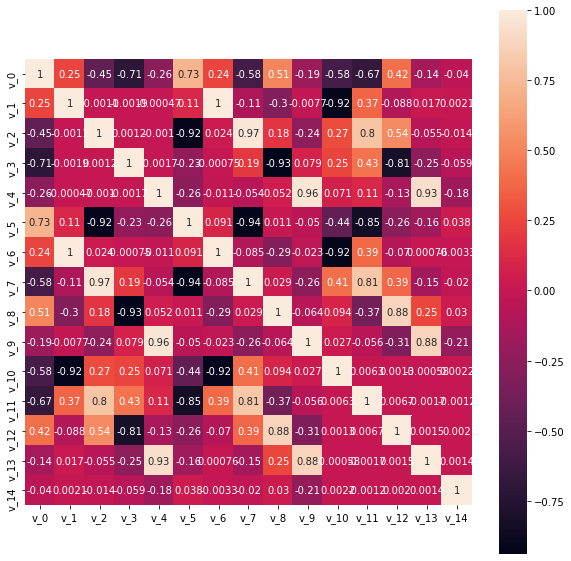

In [11]:
# 匿名特征之间的相关性
v_cor = train[['v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(v_cor,annot=True, square=True)

In [12]:
# 将相关性较强的drop
train.drop(columns=['v_6', 'v_7', 'v_9', 'v_13'],inplace=True)
test.drop(columns=['v_6', 'v_7', 'v_9', 'v_13'],inplace=True)

In [13]:
train.shape, test.shape

((150000, 25), (50000, 24))

#### 时间特征处理：1.Diff=end-Start; 2.离散化: 年 月 日。

In [14]:
def time_diff(data, start_time:str, end_time: str, format='%Y%m%d'):
    start = pd.to_datetime(data[start_time], format='%Y%m%d', errors='coerce')
    end = pd.to_datetime(data[end_time], format='%Y%m%d', errors='coerce')
    return (end-start).dt.days

In [15]:
train['usedDate'] = time_diff(train, 'regDate', 'creatDate')
test['usedDate'] = time_diff(test, 'regDate', 'creatDate')

In [16]:
# 由于上面的时间相减有些异常，因此需要fillna
train = train.fillna(-1)
test = test.fillna(-1)

In [17]:
train.gearbox = round(train.gearbox)
train.notRepairedDamage = round(train.notRepairedDamage)
train.fuelType = round(train.fuelType)
train.bodyType = round(train.bodyType)

test.gearbox = round(test.gearbox)
test.notRepairedDamage = round(test.notRepairedDamage)
test.fuelType = round(test.fuelType)
test.bodyType = round(test.bodyType)

In [18]:
# 标签
label = train[['price']]

In [19]:
train.drop(columns=['SaleID','price'], inplace=True)
#test.drop(columns=['SaleID'], inplace=True)

### deepFM

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import DeepFM
from deepctr.feature_column import DenseFeat, SparseFeat, get_feature_names

In [21]:
# 区分离散特征和连续特征
sparse_cols = [ 'notRepairedDamage', 'gearbox',  'brand']
dense_cols = [col for col in list(train.columns) if col not in sparse_cols]

# 对离散特征做Labelencoder
for feature in sparse_cols:
    lbe = LabelEncoder()
    train[feature] = lbe.fit_transform(train[feature])
    test[feature] = lbe.transform(test[feature])
# 对连续特征做归一化
mns = MinMaxScaler()
train[dense_cols] = mns.fit_transform(train[dense_cols])
test[dense_cols] = mns.transform(test[dense_cols])

# Sparse 和 Dense feature
sparsefeat = [SparseFeat(col, vocabulary_size=train[feature].nunique(), embedding_dim=64) for col in sparse_cols]
densefeat = [DenseFeat(col, dimension=1) for col in dense_cols]                                    


linear_feature_columns = sparsefeat + densefeat
dnn_feature_columns = sparsefeat + densefeat

feature_names = get_feature_names(linear_feature_columns+dnn_feature_columns)

#### densefeat = [DenseFeat(col, dimension=1) for col in dense_cols]   
#### 这一步经常错，dimension是输入特征的维度 

In [22]:
# 对label 做归一化
label_mns = MinMaxScaler()
label = label_mns.fit_transform(label)
#result = label_mns.inverse_transform(result)

In [23]:
# 切分训练集和线下测试集
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
y_test = label_mns.inverse_transform(y_test)

train_model_input = {name:x_train[name].values for name in feature_names}
test_model_input = {name:x_test[name].values for name in feature_names}

# 线上测试集
submission_input = {name:test[name].values for name in feature_names}

In [24]:
deepfm = DeepFM(linear_feature_columns=linear_feature_columns,
                  dnn_feature_columns=dnn_feature_columns,
                  dnn_hidden_units=(128,64),
                  task='regression')
deepfm.compile('adam', 'mae', metrics=['mae'])
history = deepfm.fit(train_model_input, y_train, batch_size=512, epochs=500, verbose=True, validation_split=0.2)

Epoch 1/500


e:\tool\python36\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


188/188 [==============================] - 1s 6ms/step - loss: 0.0672 - mae: 0.0672 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 2/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 3/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0235 - val_mae: 0.0235
Epoch 4/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 5/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 6/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0121 - mae: 0.0120 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 7/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0089 - val_mae: 0.0089
Epoch 8/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0092

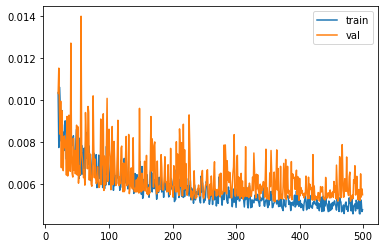

In [25]:
# 绘制loss曲线
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']               
plt.plot(range(20,len(train_loss)), train_loss[20:len(train_loss)],  label='train')
plt.plot(range(20,len(val_loss)), val_loss[20:len(val_loss)], label='val')
plt.legend()

In [26]:
def stats(data):
    print('min', data.min())
    print('max', data.max())
    print('mean', data.mean())
    print('std', data.std())

In [27]:
# 预测及反归一化
prediction = deepfm.predict(test_model_input, batch_size=512)
prediction = label_mns.inverse_transform(prediction)

# stats(prediction)

# 将小于11的值规范到11，（11为训练集label的最小值）
prediction[prediction<11] = 11

# print('规范后......')
# stats(prediction)

# 线下测试结果
mean_absolute_error(y_test, prediction)

531.3887778960864

In [28]:
# print('lable的统计特征：')
# stats(y_test)
# print('预测结果的统计特征：')
# stats(prediction)

In [29]:
# 保存模型
deepfm.save('deepfm.h5')
# 加载模型
deepfm.load_weights('deepfm.h5')

#### 线上测试集预测

In [30]:
y_pred = deepfm.predict(submission_input, batch_size=512)
y_pred = label_mns.inverse_transform(y_pred)
y_pred[y_pred<11] = 11

In [31]:
stats(y_pred)

min 11.0
max 95139.79
mean 5793.8335
std 7173.037


In [32]:
result = pd.DataFrame()
result['SaleID'] = test['SaleID']
result['price'] = y_pred
result.to_csv('submission.csv', index=False)

#### 上榜了

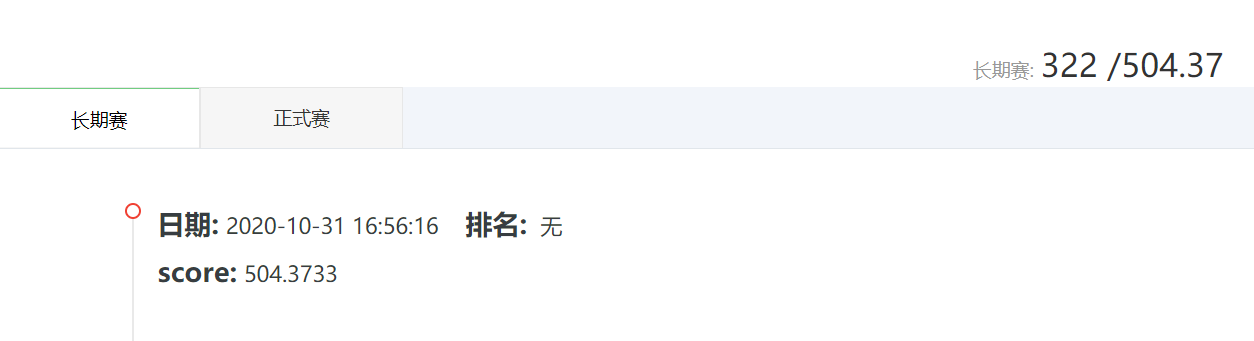